# Analysis of apartments rent in Dubai, UAE
 For **DIFC** and **Downtown** area

## Preparations

All data was scraped from Bayut website on August 9 and saved as .CSV file.  
First downloading .CSV file from Google Drive with command `! gdown`

In [89]:
! gdown 1EMlXkq1MI4HqYwbcvTl93bKZ2BvRqDCy

Downloading...
From: https://drive.google.com/uc?id=1EMlXkq1MI4HqYwbcvTl93bKZ2BvRqDCy
To: /content/bayut-dubai-difc-downtown.csv
100% 8.85M/8.85M [00:00<00:00, 117MB/s]


Importing all necessary libraries

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [91]:
sns.set_style('darkgrid')

Loading .CSV file with pandas using python engine and checking first 5 rows of data

In [92]:
data = pd.read_csv('bayut-dubai-difc-downtown.csv', engine='python')

In [93]:
pd.set_option("display.max_columns", None)

In [94]:
data.head(5)

,web-scraper-order,web-scraper-start-url,pagination,apartmet-link,apartmet-link-href,building,price,rent-frequency,address,beds,baths,area-sqft,description-title,description,reference-no,date-added,balcony-size-sqft,parking,building-info-name,building-info-floors,building-info-year,building-info-area-sqft,furnishing,features-amenities
0,1660037380-2176,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-5975062...,NaN,"190,000",Yearly,"The Address The Blvd, Downtown Dubai, Dubai",1 Bed,2 Baths,905 sqft,1 BR Luxury Unit | Serviced | Fully Furnished,Betterhomes are proud to present this stunning...,Bayut - BHM-R-556121,23 May 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,Centrally Air-Conditioned
1,1660040273-2805,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-5937929...,NaN,"165,000",Yearly,"Downtown Views, Downtown Dubai, Dubai",2 Beds,3 Baths,"1,250 sqft",All Inclusive 15K Monthly | High Floor | Full...,We are delighted to present this fully furnish...,Bayut - MK-R-5701-07-P,10 May 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,Parking Spaces: 1
2,1660036840-2061,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-5577993...,NaN,"290,000",Yearly,"BLVD Heights Tower 2, BLVD Heights, Downtown D...",2 Beds,3 Baths,"1,759 sqft",AVAILABLE NOW | DUPLEX UNIT | HIGH FLOOR,Housess Global Real Estate is pleased to offer...,Bayut - 879-Ap-R-1951,4 July 2022,NaN,NaN,NaN,NaN,NaN,NaN,Unfurnished,Swimming Pool
3,1660042132-3219,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-5942993...,NaN,"185,000",Yearly,"The Address The Blvd, Downtown Dubai, Dubai",1 Bed,2 Baths,905 sqft,DIFC View | Vacant | Fully Furnished | 1 BR,"Features:\n- 1 bed,\n- 24/7 Security,\n- Pool,...",Bayut - BHM-R-555721,12 May 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,Centrally Air-Conditioned
4,1660045614-3922,https://www.bayut.com/to-rent/apartments/dubai...,https://www.bayut.com/to-rent/apartments/dubai...,NaN,https://www.bayut.com/property/details-6196723...,NaN,"130,000",Yearly,"Downtown Views, Downtown Dubai, Dubai",1 Bed,2 Baths,861 sqft,Available Now | Fully Furnished | Brand New,Brought to you by McCone Properties Properties...,Bayut - MCC-R-5685,3 August 2022,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,NaN


There's a few columns that is not valuable for future analysis such as links, IDs, rent frequency as its only contains annual rent options.  
Let's drop those columns.

In [95]:
data.drop(['apartmet-link-href','rent-frequency','web-scraper-order','web-scraper-start-url','pagination','apartmet-link', 'building'], axis=1, inplace=True)

In [96]:
# for col in data.columns:
#     print(col)
data.columns

Index(['price', 'address', 'beds', 'baths', 'area-sqft', 'description-title',
       'description', 'reference-no', 'date-added', 'balcony-size-sqft',
       'parking', 'building-info-name', 'building-info-floors',
       'building-info-year', 'building-info-area-sqft', 'furnishing',
       'features-amenities'],
      dtype='object')

First view on data info if there are anything odd or interesting insights

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    4824 non-null   object 
 1   address                  4824 non-null   object 
 2   beds                     4824 non-null   object 
 3   baths                    4802 non-null   object 
 4   area-sqft                4824 non-null   object 
 5   description-title        4824 non-null   object 
 6   description              4824 non-null   object 
 7   reference-no             4824 non-null   object 
 8   date-added               4824 non-null   object 
 9   balcony-size-sqft        1069 non-null   object 
 10  parking                  1188 non-null   object 
 11  building-info-name       1184 non-null   object 
 12  building-info-floors     1184 non-null   float64
 13  building-info-year       1184 non-null   float64
 14  building-info-area-sqft 

Price is an object, that should be changed as number of beds, baths and some othere data.  
Some data are missing, we will deal with that later

In [98]:
data.sample()

,price,address,beds,baths,area-sqft,description-title,description,reference-no,date-added,balcony-size-sqft,parking,building-info-name,building-info-floors,building-info-year,building-info-area-sqft,furnishing,features-amenities
2642,"209,000","Roda Al Murooj, Al Murooj Complex, DIFC, Dubai",3 Beds,3 Baths,"2,207 sqft",Free Wi-Fi |Close to Dubai Mall |Fully Furnished,This contemporary and chic three-bedroom apart...,Bayut - 1014-Ap-R-0010,18 June 2019,NaN,NaN,NaN,NaN,NaN,NaN,Furnished,Furnished


## Data Preprocessing

### Price column

For column with price converting it to data type int, but first removing comma.

In [99]:
data['price'] = data['price'].str.replace(',','').astype(float).astype(int)
data['price'].sample(5)

1672    160000
2420    250000
1175    320000
48      200000
4546    115000
Name: price, dtype: int64

### Bedrooms column

For column with number of bedrooms, let's see how many unique values are there and then replace it with a number, if that is a studio then replace it with 0.

In [100]:
data['beds'].unique()

array(['1 Bed', '2 Beds', 'Studio', '3 Beds', '4 Beds', '5 Beds'],
      dtype=object)

In [101]:
data['beds'] = data['beds'].replace(
    {'Studio': 0,
     '1 Bed': 1,
     '2 Beds': 2,
     '3 Beds': 3,
     '4 Beds': 4,
     '5 Beds': 5,
    }
  )


### Address column

For column with address, it has name of the city, area, bulding name or even a complecs of buildings name.  
We need it to be separated to diferent columns for future analysis. We can see that a bulding name is always goes first, city is always the last and before city is area name.  
So, let's split the address and save each element to a new column.

In [102]:
data['address_city'] = data['address'].str.split(', ').str[-1]
data['address_area'] = data['address'].str.split(', ').str[-2]
data['address_building'] = data['address'].str.split(', ').str[0]

In [103]:
data[['address', 'address_city', 'address_area', 'address_building']].sample(5)

,address,address_city,address_area,address_building
2529,"Opera Grand, Downtown Dubai, Dubai",Dubai,Downtown Dubai,Opera Grand
633,"South Ridge 1, South Ridge Towers, Downtown Du...",Dubai,Downtown Dubai,South Ridge 1
2698,"BLVD Heights Tower 1, BLVD Heights, Downtown D...",Dubai,Downtown Dubai,BLVD Heights Tower 1
3535,"Violet, Al Murooj Complex, DIFC, Dubai",Dubai,DIFC,Violet
3958,"The Address Fountain Views 1, The Address Resi...",Dubai,Downtown Dubai,The Address Fountain Views 1


We no longer needed column with address, let's drop it.

In [104]:
data.drop(['address'], axis=1, inplace=True)

### Bathrooms column

Similar to bedrooms column first checking unique values and then will replace it with numbers to have it as an int data type. Also there are 22 missing values.

In [105]:
data['baths'].unique()

array(['2 Baths', '3 Baths', '1 Bath', '5 Baths', '4 Baths', nan,
       '6 Baths'], dtype=object)

In [106]:
len(data[data['baths'].isnull()])

22

As we can see there's many apartments with huge area and a few bedrooms, at least it should have 1 bathrom.  
However, if we will fill mising values with 1 it might confuse our next analysis.  As it is only 22 missings we can just drop it. 
But, maybe later will comback to this and try to extract info from other columns such as description column.

On the next step will drop missing values, replace strings to numbers and check unique values.

In [107]:
data.dropna(subset=['baths'], inplace=True)

In [108]:
data['baths'] = data['baths'].replace(
    {'1 Bath': 1,
     '2 Baths': 2,
     '3 Baths': 3,
     '4 Baths': 4,
     '5 Baths': 5,
     '6 Baths': 6,
    }
  ).astype(int)

In [109]:
data['baths'].unique()

array([2, 3, 1, 5, 4, 6])

### Area (sqft) column

Replace commas and sqft then convert to int data type. Check first 5 rows.

In [110]:
data['area-sqft'] = (
    data['area-sqft']
    .str.replace('sqft','')
    .str.replace(',','')
    .astype(float)
    .astype(int)
    )
data['area-sqft'].head(5)

0     905
1    1250
2    1759
3     905
4     861
Name: area-sqft, dtype: int64

### Date column

Converting column with date to datetime format

In [111]:
data['date-added'] = pd.to_datetime(data['date-added'], format = "%d %B %Y")

Adding four new columns with year, month, day and weekday

In [112]:
data['year'] = pd.DatetimeIndex(data['date-added']).year 
data['month'] = pd.DatetimeIndex(data['date-added']).month 
data['day'] = pd.DatetimeIndex(data['date-added']).day
data['weekday'] = pd.DatetimeIndex(data['date-added']).weekday

In [113]:
data[['date-added', 'year', 'day', 'month', 'weekday']].head(5)

,date-added,year,day,month,weekday
0,2022-05-23,2022,23,5,0
1,2022-05-10,2022,10,5,1
2,2022-07-04,2022,4,7,0
3,2022-05-12,2022,12,5,3
4,2022-08-03,2022,3,8,2


### Furnishing column

In [114]:
data['furnishing'].unique()

array(['Furnished', 'Unfurnished', nan], dtype=object)

Replacing **NaN** with **-1** value, **Furnished** as **1** and **Unfurnished** as **0**

In [115]:
data['furnishing'] = data['furnishing'].fillna(-1)

In [116]:
data['furnishing'] = data['furnishing'].replace(
    {'Furnished': 1,
     'Unfurnished': 0,
    }
  ).astype(int)

In [117]:
data['furnishing'].unique()

array([ 1,  0, -1])

### Balcony (sqft) column

Replacing missing values with string **'-1'**, then with the rest dropping sqft and converting to int data type.

In [118]:
data['balcony-size-sqft'] = data['balcony-size-sqft'].fillna('-1')

In [119]:
data['balcony-size-sqft'] = (
    data['balcony-size-sqft']
    .str.replace('sqft','')
    .str.replace(',','')
    .astype(float)
    .astype(int)
    )

### Parking

Some listings are missing parking information, will replace it with 0. However, such information might be in description or other text columns. 

In [120]:
data['parking'] = data['parking'].fillna('No')

In [121]:
data['parking'] = data['parking'].replace(
    {'Yes': 1,
     'No': 0,
    }
  ).astype(int)

### Building info name

As earlier building name was extracted from full address column and saved in new, this one could be dropped. Before that, let's check if names actualy match.

In [122]:
data[['building-info-name', 'address_building']].sample(10)

,building-info-name,address_building
446,NaN,The Address Dubai Mall
2422,NaN,BLVD Heights Tower 2
4108,NaN,The Address Fountain Views 1
720,NaN,Tajer Residence
3673,NaN,Downtown Views
4083,NaN,Bellevue Tower 1
1374,Burj Khalifa Zone 4,Burj Khalifa
3399,Address Fountain Views Residences - Tower 1,The Address Fountain Views 1
4426,NaN,The Residence 4
488,NaN,The Address Downtown Hotel (Lake Hotel)


In [123]:
data.drop(['building-info-name'], axis=1, inplace=True)

### Building info floors

Number of floors, some buildings are missing that information and temporary will replace it with **0** 

In [124]:
data['building-info-floors'].unique()

array([nan, 73., 19., 55., 23., 56.,  9., 40., 30., 31., 41.,  4., 51.,
       20., 33., 65., 17., 21., 62., 16., 43., 18., 45.,  5., 34., 39.,
       25.,  8., 48., 36., 32., 28., 64., 27., 60., 52., 47., 24., 26.,
        6.,  7., 12., 42.])

In [125]:
data['building-info-floors'] = data['building-info-floors'].fillna(0)

In [126]:
data['building-info-floors'] = data['building-info-floors'].astype(int)

### Building info year

Will do the same for building completion year. Temporary replace missing values with **0** and change data type.

In [127]:
data['building-info-year'].unique()

array([  nan, 2021., 2012., 2019., 2017., 2008., 2013., 2010., 2020.,
       2009., 2018., 2022., 2016., 2015.])

In [128]:
data['building-info-year'] = data['building-info-year'].fillna(0)

In [129]:
data['building-info-year'] = data['building-info-year'].astype(int)

### Building info area (sqft)

For a few reasons will drop this column. First it is not so easy to find such information and get that data on each building, second reason is that unlikely total area of a buklding will affect rent prices more that number of floors or location.

In [130]:
data.drop(['building-info-area-sqft'], axis=1, inplace=True)

### Features and amenities

Missing values will replace with **Unknown**

In [131]:
data['features-amenities'] = data['features-amenities'].fillna('Unknown')

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4823
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   price                 4802 non-null   int64         
 1   beds                  4802 non-null   int64         
 2   baths                 4802 non-null   int64         
 3   area-sqft             4802 non-null   int64         
 4   description-title     4802 non-null   object        
 5   description           4802 non-null   object        
 6   reference-no          4802 non-null   object        
 7   date-added            4802 non-null   datetime64[ns]
 8   balcony-size-sqft     4802 non-null   int64         
 9   parking               4802 non-null   int64         
 10  building-info-floors  4802 non-null   int64         
 11  building-info-year    4802 non-null   int64         
 12  furnishing            4802 non-null   int64         
 13  features-amenities

## Exploratory Data Analysis (EDA)

Defining some functions for future use in analysis

In [133]:
def whiskers_limits(series):
    q1 = np.percentile(series, 25)  # Q1
    q2 = np.percentile(series, 50)  # Q2 (Median)
    q3 = np.percentile(series, 75)  # Q3
    whisker_maximum = round(q3 + ((q3 - q1) * 1.5), 2) # “maximum”: Q3 + 1.5 * IQR 
    whisker_minimum = round(q1 - ((q3 - q1) / 1.5), 2) # “minimum”: Q1 - 1.5 * IQR
    above_whisker_maximum = data.query('@series > @whisker_maximum')[series.name].count()
    total_amount = data[series.name].count()
    
    print(f"{whisker_minimum} - Minimum value for left 'whisker'\n"
          f"{whisker_maximum} - Max value for right 'whisker',\n"
          f"{above_whisker_maximum} (or {round(above_whisker_maximum / total_amount * 100, 2)}%)"
          f" of {total_amount} - N elements after the right 'whisker'")

### Price

Let's see how prices vary for all listings

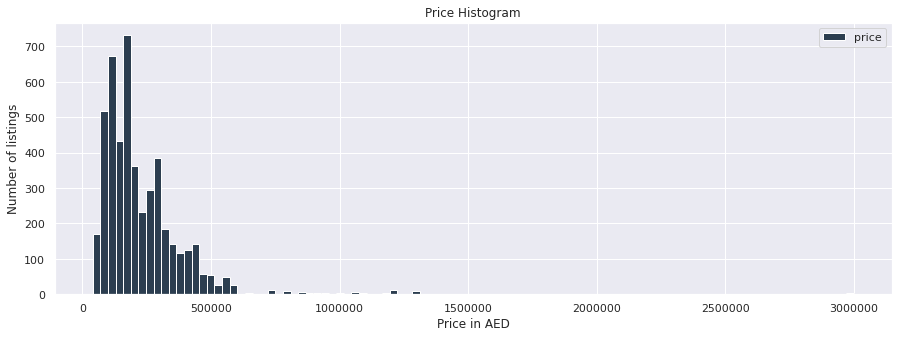

In [134]:
data['price'].plot(
    kind = 'hist',
    bins = 100,
    # range = (0, 25_000_000),
    title = "Price Histogram",
    figsize = (15, 5),
    grid = True,
    legend = True,
    color = '#2c3e50',
)
plt.ylabel('Number of listings')
plt.xlabel('Price in AED')
plt.ticklabel_format(axis='x', style='plain')
# plt.xticks(np.arange(0, 600_000, 10_000))
plt.show()

We can see outliers messing all data starting from price 500,000 and up. Most likely it's huge apartment with many rooms and more luxurious.  
We would need to look into more common range of prices.

In [135]:
pd.options.display.float_format = '{:.2f}'.format
# pd.reset_option('display.float_format')

In [136]:
data['price'].describe()

count      4802.00
mean     228229.83
std      171535.69
min       40000.00
25%      120000.00
50%      180000.00
75%      295000.00
max     3000000.00
Name: price, dtype: float64

Using method describe it's easy to see that all prices start as minimum 40,000. Enormous difference between third quartile and max value.

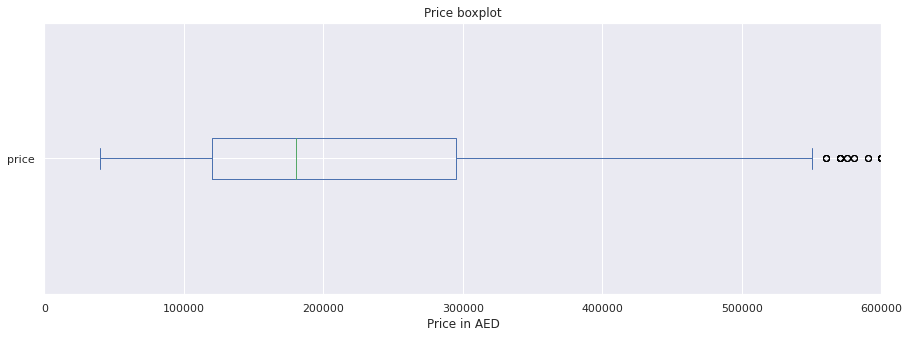

In [137]:
data['price'].plot(
    kind='box',
    title = "Price boxplot",
    figsize = (15, 5),
    grid = True,
    vert = False,
)
plt.xlim(0, 600_000)
plt.xlabel('Price in AED')
plt.show()

In [138]:
whiskers_limits(data['price'])

3333.33 - Minimum value for left 'whisker'
557500.0 - Max value for right 'whisker',
126 (or 2.62%) of 4802 - N elements after the right 'whisker'


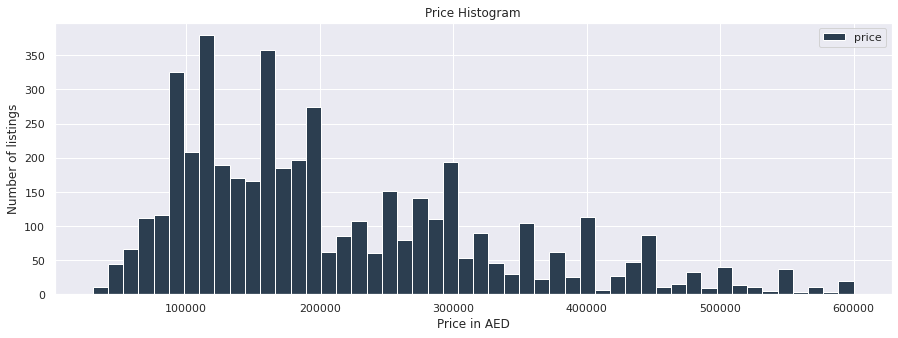

In [139]:
data['price'].plot(
    kind = 'hist',
    bins = 50,
    range = (30_000, 600_000),
    title = "Price Histogram",
    figsize = (15, 5),
    grid = True,
    legend = True,
    color = '#2c3e50',
)
plt.ylabel('Number of listings')
plt.xlabel('Price in AED')
plt.ticklabel_format(axis='x', style='plain')
# plt.xticks(np.arange(30_000, 600_000, 10_000))
plt.show()

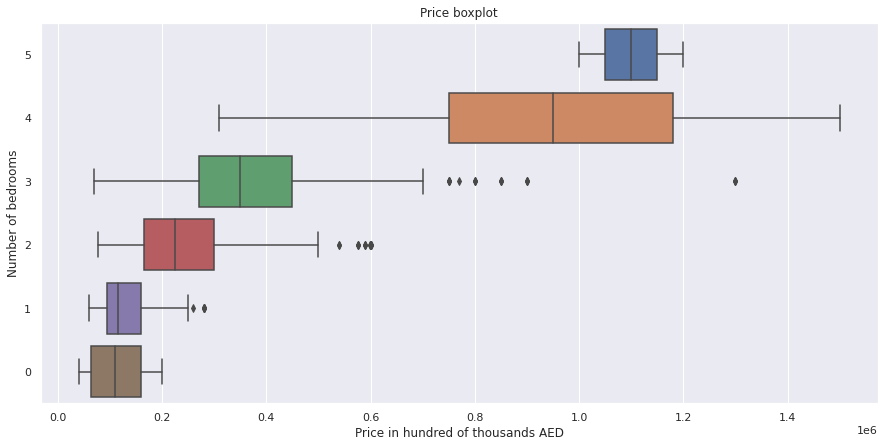

In [140]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(data = data.query('price < 2_000_000')[['price', 'beds']], #data[['price', 'beds']],
            x = 'price',
            y = 'beds',
            orient = "h",
            order = [5,4,3,2,1,0],
            )
plt.title('Price boxplot')
plt.ylabel('Number of bedrooms')
plt.xlabel('Price in hundred of thousands AED')
plt.show()

### Number of bedrooms

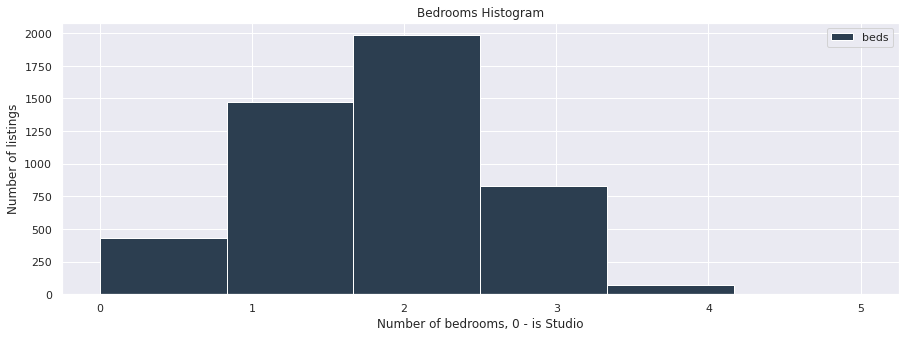

In [141]:
data['beds'].plot(
    kind = 'hist',
    title = "Bedrooms Histogram",
    bins = 6,
    figsize = (15, 5),
    grid = True,
    legend = True,
    color = '#2c3e50',
)
plt.ylabel('Number of listings')
plt.xlabel('Number of bedrooms, 0 - is Studio')
plt.ticklabel_format(axis='x', style='plain')
plt.show()

In [142]:
data['beds'].value_counts()

2    1983
1    1474
3     832
0     435
4      75
5       3
Name: beds, dtype: int64

More listings of two bedroom apartemnts followed by one bedroom

#### One bedroom apartments (1BDR)

In [143]:
data_1BDR = data.query('beds == 1')

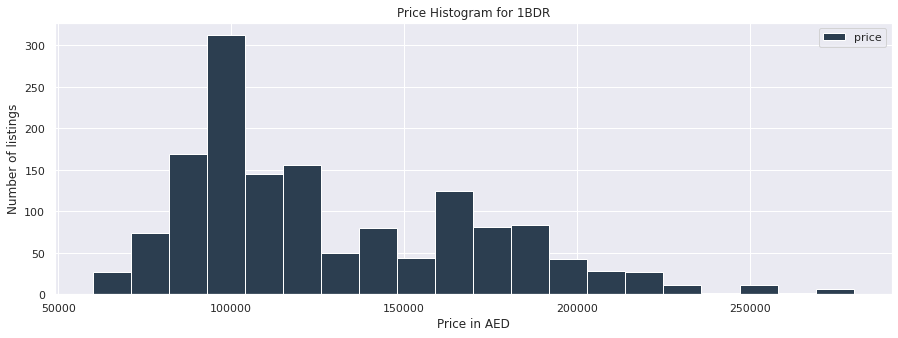

In [144]:
data_1BDR['price'].plot(
    kind = 'hist',
    bins = 20,
    # range = (30_000, 600_000),
    title = "Price Histogram for 1BDR",
    figsize = (15, 5),
    grid = True,
    legend = True,
    color = '#2c3e50',
)
plt.ylabel('Number of listings')
plt.xlabel('Price in AED')
plt.ticklabel_format(axis='x', style='plain')
plt.show()

In [145]:
data_1BDR['price'].describe()

count     1474.00
mean    128599.18
std      42612.28
min      59998.00
25%      95000.00
50%     115000.00
75%     160000.00
max     280000.00
Name: price, dtype: float64

In [146]:
data_1BDR[['price', 'area-sqft', 'baths']].corr()

,price,area-sqft,baths
price,1.00,0.05,0.07
area-sqft,0.05,1.00,0.21
baths,0.07,0.21,1.00


### Area 

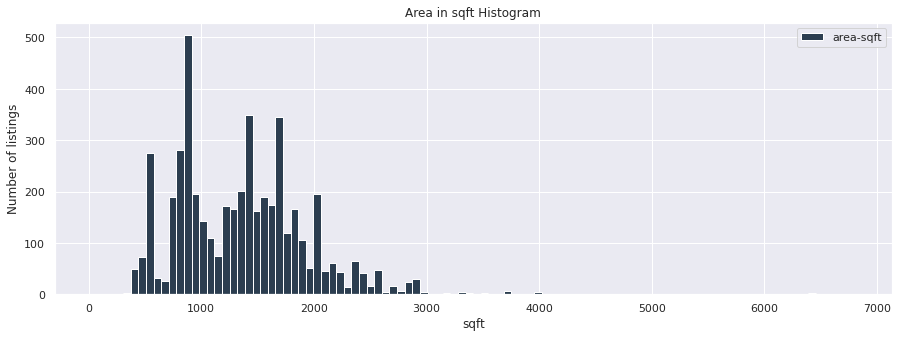

In [147]:
data['area-sqft'].plot(
    kind = 'hist',
    bins = 100,
    # range = (0, 25_000_000),
    title = "Area in sqft Histogram",
    figsize = (15, 5),
    grid = True,
    legend = True,
    color = '#2c3e50',
)
plt.ylabel('Number of listings')
plt.xlabel('sqft')
plt.ticklabel_format(axis='x', style='plain')
# plt.xticks(np.arange(0, 600_000, 10_000))
plt.show()